## EXERCISE 3

Study the data in the file x_XGB_24.dat (N=2000 samples) with labels y_XGB_24.dat. The dataset should be split into N' training samples and N'' validation samples, with N' + N'' = N

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13


import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten 
from keras.layers import Conv1D, Input

XGBoost version: 2.0.3


In [2]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
N1=N_train/N
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=1-N1, random_state=42)
print(f"N={N}, N_train={N_train}, L={L}")


N=4000, N_train=3000, L=4


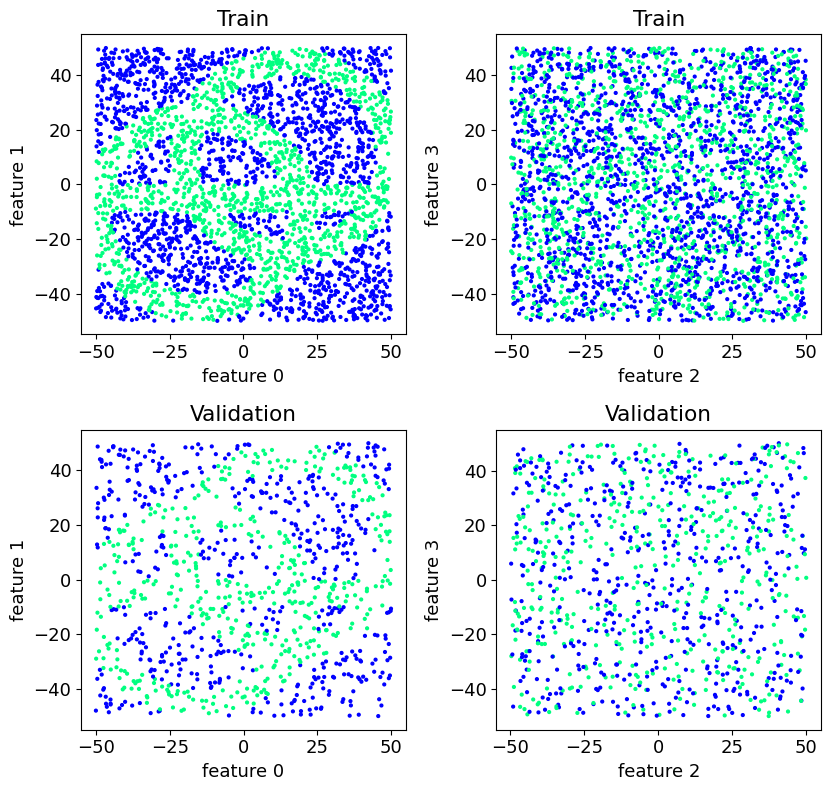

In [3]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

fig, AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_val,y_val,title="Validation")
scat(AX[1,1],x_val,y_val,i=2,j=3,title="Validation")
fig.tight_layout()
plt.show()

### 1\. Model complexity, parameters’ and regularization
Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model that keeps a good validation accuracy? Is regularization useful for this analysis?

In [4]:
def classify(clf=GradientBoostingClassifier(),show=False):
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_val)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_val, y_val)), clf.score(x_val, y_val)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig, AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    """
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show() 
    """

errors: 4.90%   Accuracy=0.951


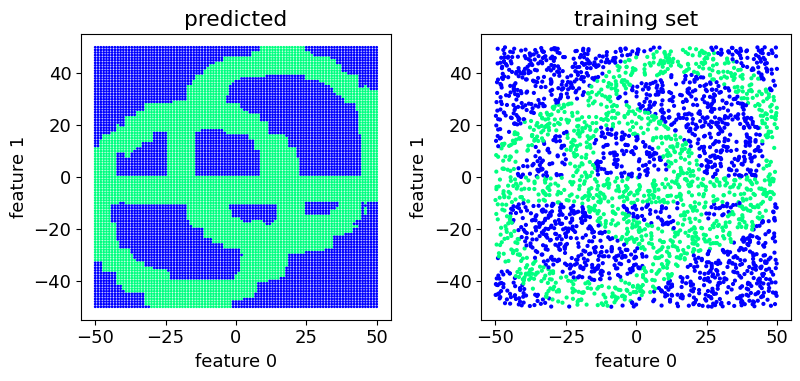

In [5]:
model = XGBClassifier(seed=1, 
                      objective='binary:logistic')

classify(model, show=True)

In [6]:
# FUNCTION FOR LOOKING FOR THE BEST MODEL

def find_best_model(x_train, y_train, x_val, y_val):
    parameters = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'n_estimators': [10, 50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'reg_lambda': [0.001, 0.01, 0.1, 0],
        'reg_alpha': [0.001, 0.01, 0.1, 0],
        'gamma': [0, 0.1, 0.2, 0.3]
    }

    model = XGBClassifier(seed=1, objective='binary:logistic')
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=3, scoring='accuracy')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy on Training Set:", best_score)

    # Train the model on the combined training and validation set using best parameters
    best_model = XGBClassifier(**best_params, seed=1, objective='binary:logistic')
    best_model.fit(x_train, y_train)

    # Evaluate the best model on the validation set
    y_pred_val = best_model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print("Accuracy on Validation Set:", val_accuracy)

    return best_model, best_params, val_accuracy


In [7]:
# FIND BEST MODEL AND BEST PARAMETERS

best_model, best_params, validation_accuracy = find_best_model(x_train, y_train, x_val, y_val)

KeyboardInterrupt: 

In [ ]:
xgb_model_no_reg = XGBClassifier()
xgb_model_no_reg.fit(x_train, y_train)
y_pred_no_reg = xgb_model_no_reg.predict(x_val)
accuracy_no_reg = accuracy_score(y_val, y_pred_no_reg)
print("Validation Accuracy without Regularization:", accuracy_no_reg)

Validation Accuracy without Regularization: 0.8856666666666667


errors: 12.10%   Accuracy=0.879


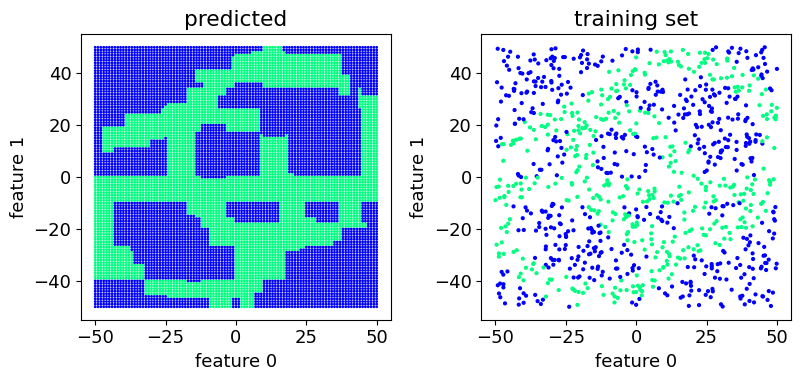

Validation Accuracy without Regularization: 0.8856666666666667
Validation Accuracy with Regularization: 0.879


In [ ]:
# CHECK IF THE REGULARIZATION IS HELPFUL

classify(best_model, show = True)

xgb_model_no_reg = XGBClassifier()
xgb_model_no_reg.fit(x_train, y_train)
y_pred_no_reg = xgb_model_no_reg.predict(x_val)
accuracy_no_reg = accuracy_score(y_val, y_pred_no_reg)

print("Validation Accuracy without Regularization:", accuracy_no_reg)
print("Validation Accuracy with Regularization:", validation_accuracy)

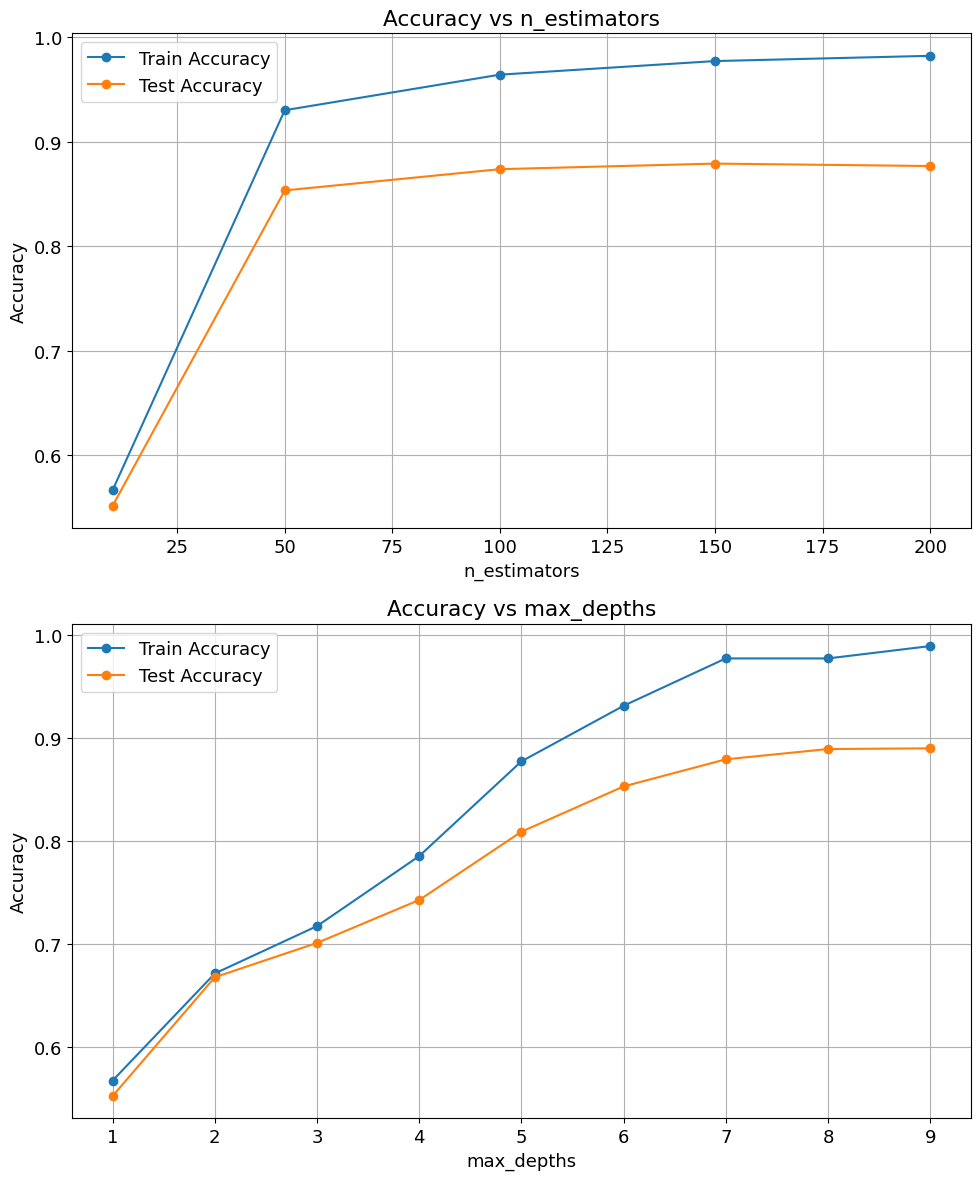

In [ ]:
n_estimators = [10, 50, 100, 150, 200]
max_depths_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot for n_estimators
train_accuracies = []
val_accuracies = []

for num in n_estimators:
    model = XGBClassifier(learning_rate=best_params['learning_rate'],
                          n_estimators=num,
                          max_depth=best_params['max_depth'],
                          reg_lambda=best_params['reg_lambda'],
                          reg_alpha=best_params['reg_alpha'],
                          gamma=best_params['gamma'],
                          seed=1,
                          objective='binary:logistic')

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    y_test_pred = model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_test_pred)
    val_accuracies.append(val_accuracy)

axes[0].plot(n_estimators, train_accuracies, marker='o', label='Train Accuracy')
axes[0].plot(n_estimators, val_accuracies, marker='o', label='Test Accuracy')
axes[0].set_title('Accuracy vs n_estimators')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot for max_depths
train_accuracies = []
val_accuracies = []

for max_depth in max_depths_range:
    model = XGBClassifier(learning_rate=best_params['learning_rate'],
                          n_estimators=best_params['n_estimators'],
                          max_depth=max_depth,
                          reg_lambda=best_params['reg_lambda'],
                          reg_alpha=best_params['reg_alpha'],
                          gamma=best_params['gamma'],
                          seed=1,
                          objective='binary:logistic')

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    y_test_pred = model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_test_pred)
    val_accuracies.append(val_accuracy)

axes[1].plot(max_depths_range, train_accuracies, marker='o', label='Train Accuracy')
axes[1].plot(max_depths_range, val_accuracies, marker='o', label='Test Accuracy')
axes[1].set_title('Accuracy vs max_depths')
axes[1].set_xlabel('max_depths')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

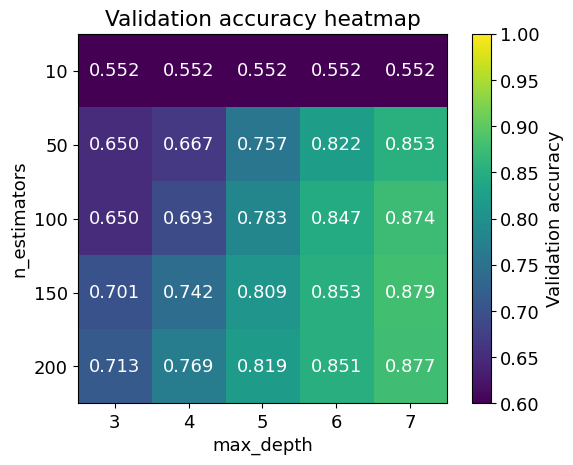

In [ ]:
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 4, 5, 6, 7]
accuracies = np.zeros((len(n_estimators), len(max_depth)))

for i, num in enumerate(n_estimators):
    for j, depth in enumerate(max_depth):
        model = XGBClassifier(learning_rate=best_params['learning_rate'], 
                              n_estimators=num, 
                              max_depth=depth, 
                              reg_lambda=best_params['reg_lambda'], 
                              reg_alpha=best_params['reg_alpha'], 
                              gamma=best_params['gamma'], 
                              seed=1, 
                              objective='binary:logistic')
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_val)
        val_accuracy = accuracy_score(y_val, y_pred_test)
        accuracies[i, j] = val_accuracy

plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Validation accuracy')
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.xticks(np.arange(len(max_depth)), max_depth)
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
plt.title('Validation accuracy heatmap')
plt.clim(0.6, 1)

# Adding text annotations
for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        plt.text(j, i, f'{accuracies[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()

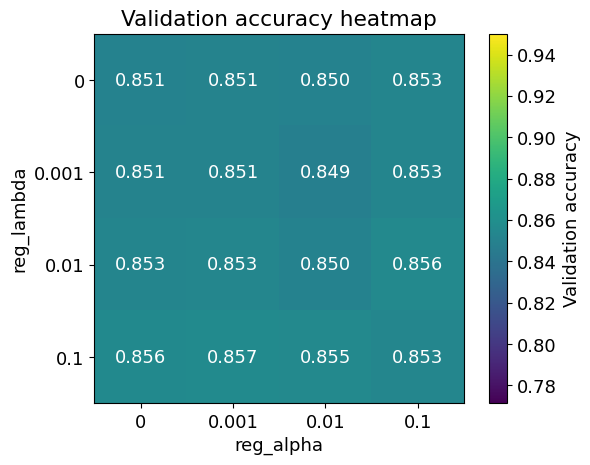

In [ ]:
reg_lambda = [0, 0.001, 0.01, 0.1]
reg_alpha = [0, 0.001, 0.01, 0.1]
accuracies = np.zeros((len(reg_lambda), len(reg_alpha)))

for i, lambd in enumerate(reg_lambda):
    for j, alpha in enumerate(reg_alpha):
        model = XGBClassifier(learning_rate=best_params['learning_rate'], 
                              n_estimators=150, 
                              max_depth=6, 
                              reg_lambda=lambd, 
                              reg_alpha=alpha, 
                              gamma=best_params['gamma'], 
                              seed=1, 
                              objective='binary:logistic')
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_val)
        val_accuracy = accuracy_score(y_val, y_pred_test)
        accuracies[i, j] = val_accuracy

plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Validation accuracy')
plt.xticks(np.arange(len(reg_alpha)), reg_alpha)
plt.yticks(np.arange(len(reg_lambda)), reg_lambda)
plt.xlabel('reg_alpha')
plt.ylabel('reg_lambda')
plt.title('Validation accuracy heatmap')
plt.clim(0.92, 0.95)


for i in range(len(reg_lambda)):
    for j in range(len(reg_alpha)):
        plt.text(j, i, f'{accuracies[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()

errors: 14.97%   Accuracy=0.850


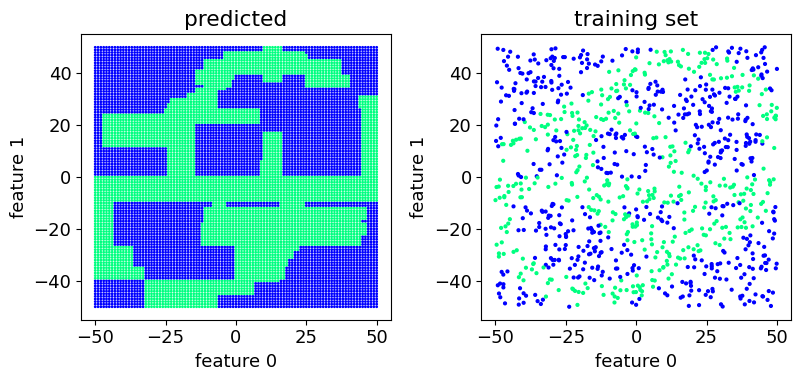

In [ ]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      # importance_type="gain" #weight, cover, ...
                      learning_rate= best_params['learning_rate'], 
                      gamma = best_params['gamma'],
                      reg_lambda=0.01, 
                      reg_alpha = 0.01,
                      n_estimators=150,
                      max_depth=6)

classify(model, show=True)

### 2\. Dimensionality reduction
Consider reduced data samples with L'\<L features. For example, feature 0,1, and 3 out of the L=4 features. Check if the exclusion of the least important feature(s) from training data leads to better accuracy.

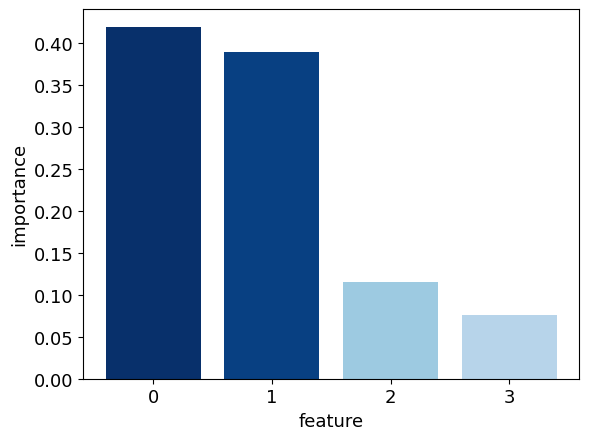

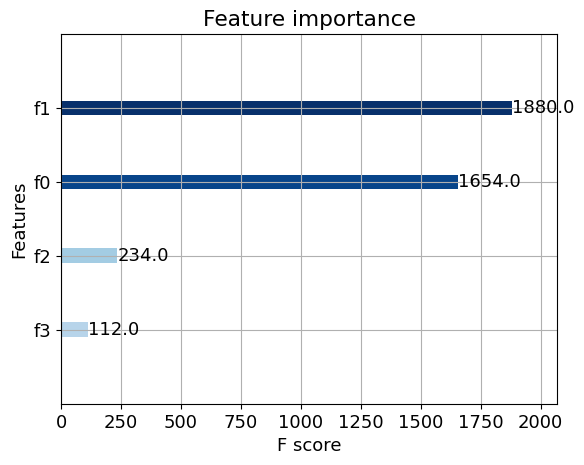

In [ ]:
my_cmap = plt.get_cmap("Blues")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))

plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

In [ ]:
original_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda = 0.01, reg_alpha = 0.01, seed=1, objective='binary:logistic')
original_model.fit(x_train, y_train)

least_important_features_indices = 2,3
x_train_reduced = np.delete(x_train, least_important_features_indices, axis=1)

reduced_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda = 0.01, reg_alpha = 0.01, seed=1, objective='binary:logistic')
reduced_model.fit(x_train_reduced, y_train)

# Evaluate both models on the test data
y_pred_original = original_model.predict(x_val)
accuracy_original = accuracy_score(y_val, y_pred_original)

y_pred_reduced = reduced_model.predict(np.delete(x_val, least_important_features_indices, axis=1))
accuracy_reduced = accuracy_score(y_val, y_pred_reduced)

print(f"Accuracy with all features: {accuracy_original}")
print(f"Accuracy with reduced features: {accuracy_reduced}")

Accuracy with all features: 0.8503333333333334
Accuracy with reduced features: 0.863


Accuracy after removing features [0]: 0.647
Accuracy after removing features [1]: 0.5773333333333334
Accuracy after removing features [2]: 0.84
Accuracy after removing features [3]: 0.857
Accuracy after removing features [0, 1]: 0.5393333333333333
Accuracy after removing features [1, 2]: 0.5933333333333334
Accuracy after removing features [2, 3]: 0.863
Accuracy after removing features [0, 2]: 0.651
Accuracy after removing features [0, 3]: 0.6423333333333333
Accuracy after removing features [1, 3]: 0.5736666666666667


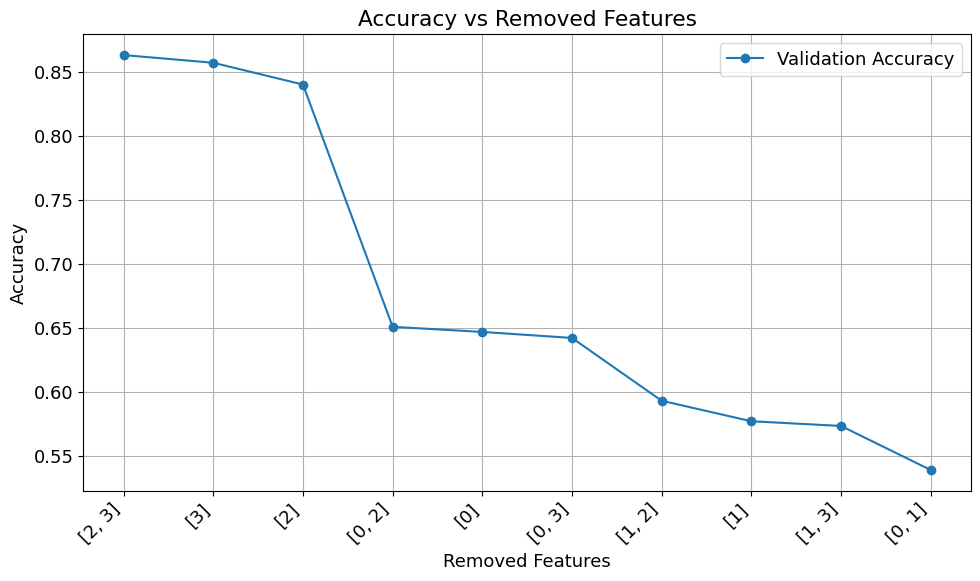

In [ ]:
least_important_features_indices = [[0], [1], [2], [3], [0, 1], [1, 2], [2, 3], [0, 2], [0, 3], [1, 3]]
accuracies = []

for indices in least_important_features_indices:
    x_train_reduced = np.delete(x_train, indices, axis=1)
    x_val_reduced = np.delete(x_val, indices, axis=1)

    reduced_model = XGBClassifier(gamma =  best_params['gamma'], learning_rate = best_params['learning_rate'], max_depth = 6, n_estimators = 150, reg_lambda = 0.01, reg_alpha = 0.01, seed=1, objective='binary:logistic')
    reduced_model.fit(x_train_reduced, y_train)
    
    y_pred_reduced = reduced_model.predict(x_val_reduced)
    accuracy_reduced = accuracy_score(y_val, y_pred_reduced)
    accuracies.append(accuracy_reduced)
    
for i, indices in enumerate(least_important_features_indices):
    print(f"Accuracy after removing features {indices}: {accuracies[i]}")

sorted_indices=sorted(range(len(accuracies)), key=lambda k: accuracies[k])
accuracies=[accuracies[i] for i in sorted_indices]

labels = [str(indices) for indices in least_important_features_indices]
labels=[labels[i] for i in sorted_indices]


plt.figure(figsize=(10, 6))
plt.plot(labels, accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs Removed Features')
plt.xlabel('Removed Features')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.gca().invert_xaxis()

plt.show()

### 3\.  XGBoost vs NN
Compare the validation accuracy of XGBoost with that of a simple feed-forward neural network (NN):
- By varying the number of data samples N’ in the training set (i.e., reducing the fraction N’/N of the data set used for training)
- With cross-validation for all cases.

Is the NN or the XGB performing significantly better at low N’?

In [8]:
# Definition of the CNN model
n_class = len(np.unique(y_train))
input_shape = (L, 1)

def build_model(NF=5, KS=6, NF2=5, KS2=3, lamb=0):
    """
    filter = kernel
    NF=number of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=number of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=lambda, the regularization parameter
    """
    reg = keras.regularizers.l2(lamb)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=NF, 
                     kernel_size=KS,
                     kernel_regularizer=reg,
                     activation='relu', 
                     padding='same'))  # Ensure output size matches input size
    model.add(Conv1D(filters=NF2, kernel_size=KS2, activation='relu', padding='same'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(n_class, activation='softmax'))
    return model

# Build the model with default parameters
model = build_model()

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 5)           │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 5)           │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 5)           │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237 (948.00 B)

 Trainable params: 237 (948.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Find the best optimizers for our dataset
optimizers = [keras.optimizers.Adam, keras.optimizers.RMSprop, keras.optimizers.SGD, keras.optimizers.Nadam]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
BATCH_SIZE = 200
EPOCHS = 300
results = []

for optimizer in optimizers:
    optimizer_name = optimizer.__name__
    mean_val_accuracies_optimizer = []
    std_val_accuracies_optimizer = []

    for learning_rate in learning_rates:
        opt = optimizer(learning_rate=learning_rate)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Training the model
        fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(x_val,y_val), verbose=0, shuffle=True)
        val_accuracies = fit.history['val_accuracy']

        mean_val_accuracy_lr = np.mean(val_accuracies)
        std_val_accuracy_lr = np.std(val_accuracies)

        mean_val_accuracies_optimizer.append(mean_val_accuracy_lr)
        std_val_accuracies_optimizer.append(std_val_accuracy_lr)

    results.append({
        'optimizer': optimizer_name,
        'learning_rates': learning_rates,
        'mean_val_accuracy': mean_val_accuracies_optimizer,
        'std_val_accuracy': std_val_accuracies_optimizer
    })
print(results)

[{'optimizer': 'Adam', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5008066695928574, 0.5945733322699864, 0.6320166671276093, 0.7048333334922791, 0.5326366592446963], 'std_val_accuracy': [0.008436585525266183, 0.024227765939908445, 0.010986797838761515, 0.031193358410291246, 0.004442744610188632]}, {'optimizer': 'RMSprop', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5329999923706055, 0.5329999923706055, 0.5329999923706055, 0.5329999923706055, 0.5307999928792317], 'std_val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.011847359836659445]}, {'optimizer': 'SGD', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5329999923706055, 0.5329999923706055, 0.5329999923706055, 0.5329999923706055, 0.5329999923706055], 'std_val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0]}, {'optimizer': 'Nadam', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5329999923706055, 0.5329999923706055, 0.5329999923706055,

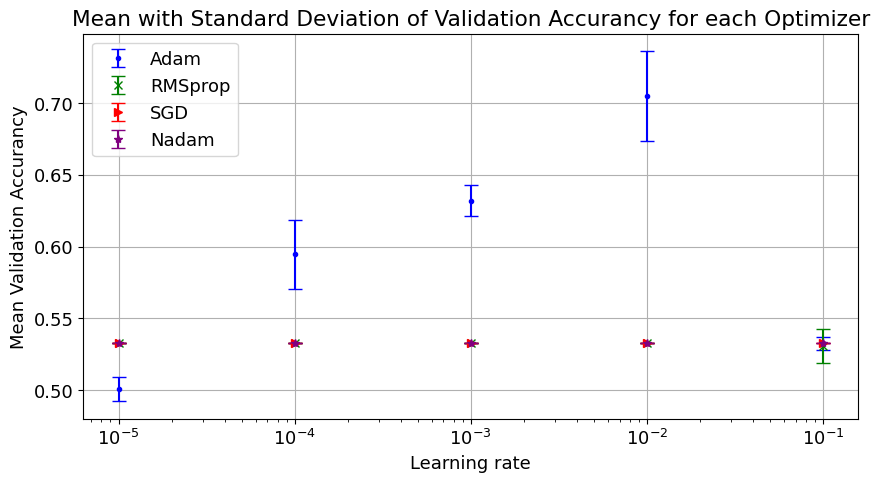

In [10]:
# Plot the validation accuracy for each optimizers
colors = ['blue', 'green', 'red', 'purple']
fmt=['.', 'x', '>', '*']
plt.figure(figsize=(10, 5))

for i, result in enumerate(results):
    optimizer_name = result['optimizer']
    learning_rates = result['learning_rates']
    mean_val_accuracy = result['mean_val_accuracy']
    std_val_accuracy = result['std_val_accuracy']
    color = colors[i]
    
    plt.errorbar(learning_rates, mean_val_accuracy, yerr=std_val_accuracy, fmt=fmt[i], capsize=5,label=optimizer_name, color=colors[i])


plt.title('Mean with Standard Deviation of Validation Accurancy for each Optimizer')
plt.xlabel('Learning rate')
plt.ylabel('Mean Validation Accurancy')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

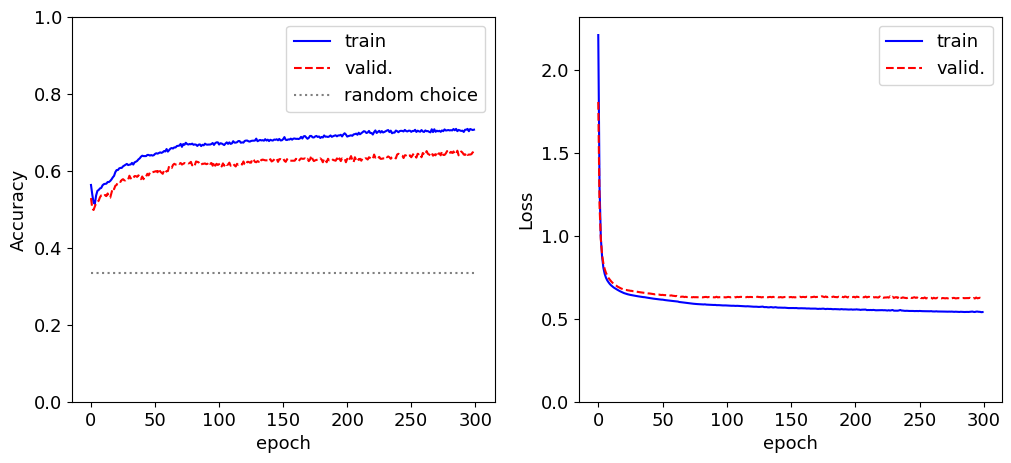

In [11]:
# Train the model with the best optimizer
model_best=build_model()
model_best.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
fit_best= model_best.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_data=(x_val,y_val), verbose=0, shuffle=True)

# Plot accuracy and loss for each epochs
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

Show_history(fit_best)

In [12]:
# Create models with diffent number of data samples
import time

N_range=[0.2,0.4,0.6,0.8]

val_accuracies=[]
svm_val_accuracies=[]
knn_val_accuracies=[]
mlp_val_accuracies=[]
xgb_val_accuracies=[]

cnn_times = []
mlp_times = []
xgb_times = []

for N1 in N_range:
    #split the dataset
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=N1, random_state=42)
    # CNN
    model_cnn=build_model()
    start_time_cnn = time.time()
    model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    fit = model_cnn.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_data=(x_val,y_val), verbose=0, shuffle=True)
    end_time_cnn = time.time()
    val_accuracy = fit.history['val_accuracy'][-1]
    # SVM
    feature_mapping=model_cnn(x_val)
    svm_classifier = SVC()
    svm_classifier.fit(feature_mapping, y_val)
    svm_val_accuracy = accuracy_score(y_val, svm_classifier.predict((feature_mapping)))
    # kNN
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(feature_mapping, y_val)
    knn_val_accuracy = accuracy_score(y_val, knn_classifier.predict((feature_mapping)))
    # MLP
    start_time_mlp = time.time()
    model_mlp =Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model_mlp.compile(optimizer='sgd', loss='mean_squared_error')
    model_mlp.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_data=(x_val,y_val), verbose=0, shuffle=True)
    end_time_mlp = time.time()
    mlp_val_accuracy = fit.history['val_accuracy'][-1]
    # XGBoost
    start_time_xgb = time.time()
    model_xgb = XGBClassifier(seed=1, objective='binary:logistic',
       learning_rate=0.1, reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)

    model_xgb.fit(x_train, y_train)
    end_time_xgb = time.time()
    y_val_pred = model_xgb.predict(x_val)
    xgb_val_accuracy = accuracy_score(y_val, y_val_pred)


    xgb_val_accuracies.append(xgb_val_accuracy)
    val_accuracies.append(val_accuracy)
    svm_val_accuracies.append(svm_val_accuracy)
    knn_val_accuracies.append(knn_val_accuracy)
    mlp_val_accuracies.append(mlp_val_accuracy)

    cnn_time= end_time_cnn - start_time_cnn
    mlp_time = end_time_mlp - start_time_mlp
    xgb_time= end_time_xgb - start_time_xgb

    cnn_times.append(cnn_time)
    mlp_times.append(mlp_time)
    xgb_times.append(xgb_time)

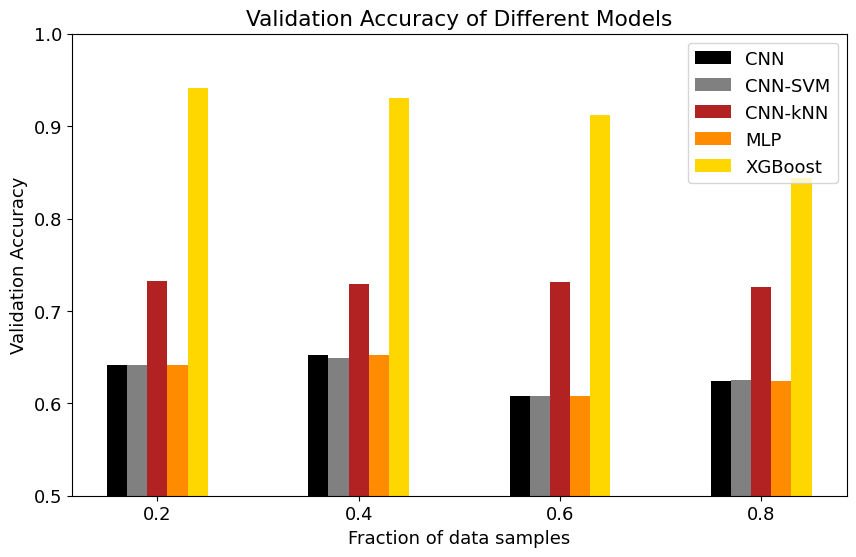

In [13]:
# Plot histogram of validation accuracies
models = ['CNN', 'CNN-SVM', 'CNN-kNN','MLP', 'XGBoost']  
color=["black","gray","firebrick","darkorange","gold"]
Nrange=["0.2","0.4","0.6","0.8"]
accuracies = [val_accuracies, svm_val_accuracies, knn_val_accuracies, mlp_val_accuracies,xgb_val_accuracies] 
plt.figure(figsize=(10, 6))

# Plot bar chart for each model
for i, (model, acc) in enumerate(zip(models, accuracies)):
    plt.bar(np.arange(len(Nrange)) + i * 0.1, acc, width=0.1, color=color[i], label=model)

plt.xlabel('Fraction of data samples')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy of Different Models')
plt.ylim(0.5, 1)
plt.xticks(np.arange(len(Nrange)) + 0.2, Nrange)
plt.legend()

plt.show()

[[29.06546640396118, 27.784101247787476, 28.464526176452637, 26.065094709396362], [18.882144689559937, 20.414841651916504, 19.064140558242798, 20.248295068740845], [0.21791744232177734, 0.205092191696167, 0.18828487396240234, 0.2085709571838379]]


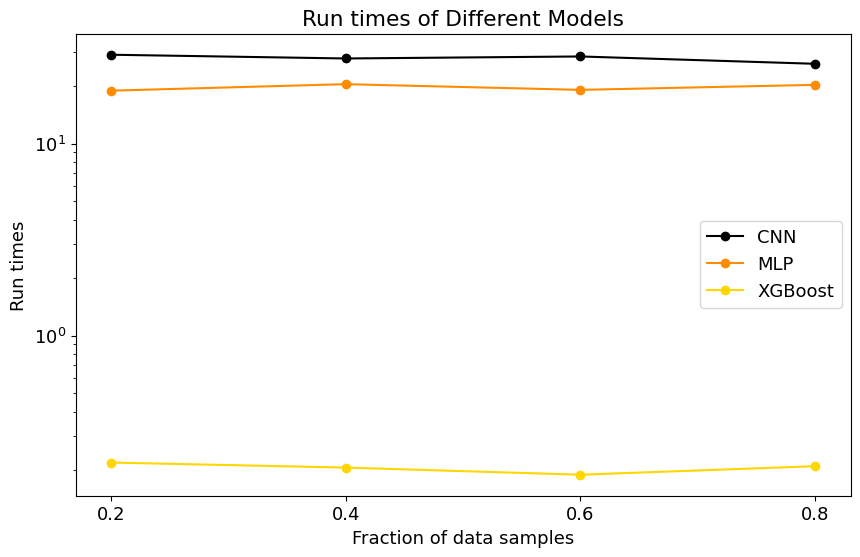

In [14]:
# Plot the run times of different models
models = ['CNN','MLP', 'XGBoost']  
color=["black","darkorange","gold"]
Nrange=["0.2","0.4","0.6","0.8"]
times = [cnn_times, mlp_times, xgb_times]
print(times)
plt.figure(figsize=(10, 6))

for i, (model, t) in enumerate(zip(models, times)):
    plt.plot(Nrange, t,marker='o', color=color[i], label=model)

plt.xlabel('Fraction of data samples')
plt.ylabel('Run times')
plt.title('Run times of Different Models')
plt.yscale('log')
plt.legend()

plt.show()

In [16]:
# Perform the cross validation
val_accuracies = []
svm_val_accuracies = []
knn_val_accuracies = []
mlp_val_accuracies = []
xgb_val_accuracies = []

val_accuracies_std=[]
svm_val_accuracies_std=[]
knn_val_accuracies_std=[]
mlp_val_accuracies_std=[]
xgb_val_accuracies_std=[]

# Define number of folds for cross-validation
k = 5
N_range=[0.2,0.4,0.6,0.8]
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for N1 in N_range:
    # Split the dataset
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=N1, random_state=42)

    # Initialize lists to store accuracy scores for each fold
    fold_val_accuracies = []
    fold_svm_val_accuracies = []
    fold_knn_val_accuracies = []
    fold_mlp_val_accuracies = []
    fold_xgb_val_accuracies = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(x_train):
        x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Train and evaluate CNN model
        model=build_model()
        model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
        fit = model.fit(x_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test_fold, y_test_fold), verbose=0, shuffle=True)
        fold_val_accuracy = fit.history['val_accuracy'][-1]
        fold_val_accuracies.append(fold_val_accuracy)

        # Train and evaluate SVM model
        svm_classifier = SVC()
        svm_classifier.fit(x_train_fold, y_train_fold)
        fold_svm_val_accuracy = accuracy_score(y_test_fold, svm_classifier.predict(x_test_fold))
        fold_svm_val_accuracies.append(fold_svm_val_accuracy)

        # Train and evaluate kNN model
        knn_classifier = KNeighborsClassifier()
        knn_classifier.fit(x_train_fold, y_train_fold)
        fold_knn_val_accuracy = accuracy_score(y_test_fold, knn_classifier.predict(x_test_fold))
        fold_knn_val_accuracies.append(fold_knn_val_accuracy)

        # Train and evaluate MLP model
        model_mlp =Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)])
        model_mlp.compile(optimizer='sgd', loss='mean_squared_error')
        model_mlp.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_data=(x_val,y_val), verbose=0, shuffle=True)
        fold_mlp_val_accuracy = fit.history['val_accuracy'][-1]
        fold_mlp_val_accuracies.append(fold_mlp_val_accuracy)

        # Train and evaluate XGBoost model
        model_xgb = XGBClassifier(seed=1,
                                  objective='binary:logistic',
                                  learning_rate=0.1,
                                  reg_lambda=0.1,
                                  reg_alpha=0.01,
                                  n_estimators=150,
                                  max_depth=6,
                                  gamma=0)
        model_xgb.fit(x_train_fold, y_train_fold)
        fold_xgb_val_accuracy = accuracy_score(y_test_fold, model_xgb.predict(x_test_fold))
        fold_xgb_val_accuracies.append(fold_xgb_val_accuracy)

    # Average accuracy scores across folds
    val_accuracies.append(np.mean(fold_val_accuracies))
    svm_val_accuracies.append(np.mean(fold_svm_val_accuracies))
    knn_val_accuracies.append(np.mean(fold_knn_val_accuracies))
    mlp_val_accuracies.append(np.mean(fold_mlp_val_accuracies))
    xgb_val_accuracies.append(np.mean(fold_xgb_val_accuracies))

    # Standard deviation of the accuracy scores across folds
    val_accuracies_std.append(np.std(fold_val_accuracies))
    svm_val_accuracies_std.append(np.std(fold_svm_val_accuracies))
    knn_val_accuracies_std.append(np.std(fold_knn_val_accuracies))
    mlp_val_accuracies_std.append(np.std(fold_mlp_val_accuracies))
    xgb_val_accuracies_std.append(np.std(fold_xgb_val_accuracies))

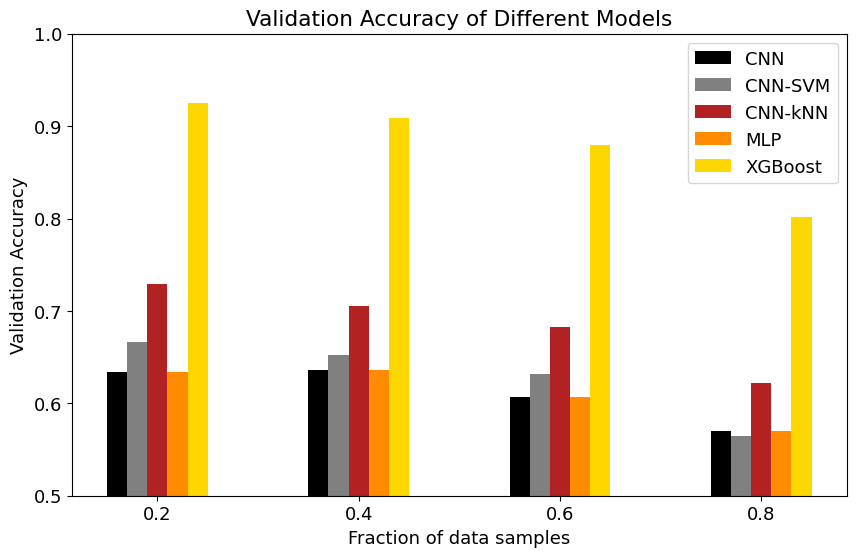

In [17]:
# Plot histogram of validation accuracies
models = ['CNN', 'CNN-SVM', 'CNN-kNN','MLP', 'XGBoost']  
color=["black","gray","firebrick","darkorange","gold"]
Nrange=["0.2","0.4","0.6","0.8"]
accuracies = [val_accuracies, svm_val_accuracies, knn_val_accuracies, mlp_val_accuracies,xgb_val_accuracies] 
plt.figure(figsize=(10, 6))

# Plot bar chart for each model
for i, (model, acc) in enumerate(zip(models, accuracies)):
    plt.bar(np.arange(len(Nrange)) + i * 0.1, acc, width=0.1, color=color[i], label=model)

plt.xlabel('Fraction of data samples')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy of Different Models')
plt.ylim(0.5, 1)
plt.xticks(np.arange(len(Nrange)) + 0.2, Nrange)
plt.legend()

plt.show()

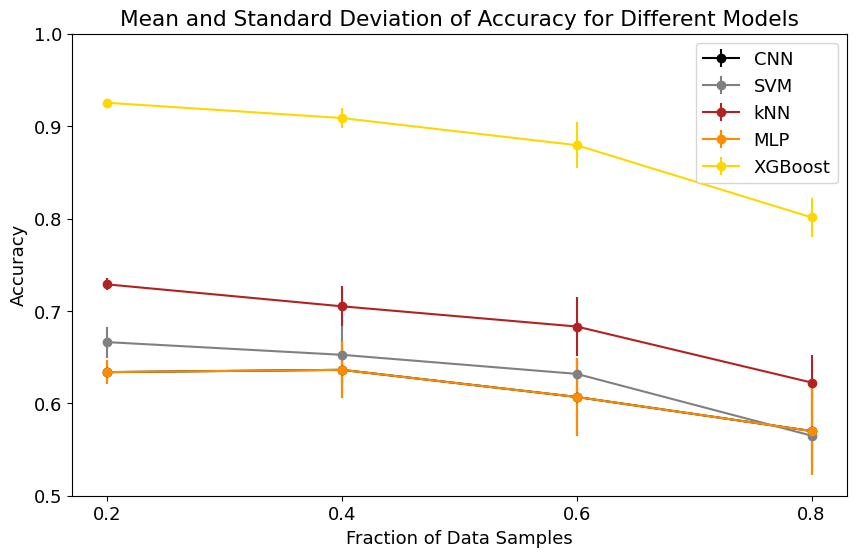

In [21]:
models = ['CNN', 'SVM', 'kNN', 'MLP', 'XGBoost']
color=["black","gray","firebrick","darkorange","gold"]
Nrange=["0.2","0.4","0.6","0.8"]
accuracies = [val_accuracies, svm_val_accuracies, knn_val_accuracies, mlp_val_accuracies, xgb_val_accuracies]
std_accuracies = [val_accuracies_std, svm_val_accuracies_std, knn_val_accuracies_std, mlp_val_accuracies_std, xgb_val_accuracies_std]

plt.figure(figsize=(10, 6))
for i, (model, acc, std) in enumerate(zip(models, accuracies, std_accuracies)):
    plt.errorbar(Nrange, acc, yerr=std, fmt='o-', color=color[i], label=model)

plt.xlabel('Fraction of Data Samples')
plt.ylabel('Accuracy')
plt.title('Mean and Standard Deviation of Accuracy for Different Models')
plt.legend()
plt.ylim(0.5, 1)

plt.show()

### Answer:
Nell'ultima parte abbiamo comparato la validation accuracy di XGBoost con quella di altri neural network per vedere quali di questi ha le migliori prestazioni. In particolare abbiamo deciso di prendere in considerazione come simple feedforward neural network un Multi-Layer Perceptron (MLP) con funzione d'attivazione ReLu e un Convolutional Neural Network (CNN) creato con la funzione build_model(). Prima di fare il fit del nostro CNN abbiamo deciso di scegliere il miglior optimizer per i nostri dati e l'analisi ci ha portato a scegliere Adam poichè ci restituisce la validation accuracy migliore, nonostante abbia una deviazione standard più elevata.
Inoltre abbiamo deciso di aggiungere come modelli anche due classificatori ibridi:  
* CNN-Support Vector Machine (SVM): la support vector machine cerca di trovare il miglior iperpiano di separazione tra le diverse classi di dati nello spazio delle caratteristiche estratte dalla CNN;
* CNN-k-Nearest Neighbors (kNN): il classificatore kNN assegna un'etichetta di classe a un punto dati basandosi sulle etichette dei suoi "vicini" più prossimi nello spazio delle caratteristiche estratte dalla CNN.

In questo modo la nostra analisi riesce a dare una spiegazione più esaustiva e dettagliata su quale sia effettivamente il miglior modello da utilizzare per il nostro dataset e quale classificatore ha le prestazioni migliori.
Inizialmente abbiamo solo variato il numero di data sample N’ in the training set mentre successivamente abbiamo applicato la cross-validation per ogni caso con KFold.
Dagli istogrammi notiamo subito che la validation accuracy con XGBoost ha un valore decisamente più elevato rispetto agli altri modelli e che diminuisce leggermente con l'aumentare del numero di data samples nel nostro training set. Infatti XGBoost performa meglio con meno dati di training e la validation accuracy con la frazione N'/N pari a 0.2 è più alta di circa 0.1 rispetto alla frazione di 0.8. Inoltre abbiamo notato che con la cross validation la validation accuracy diminuisce leggermente #spiegare meglio.

Infine abbiamo creato un grafico del tempo che ci impiega ogni modello a fittare i dati e XGBoost ha una performance significativamente più veloce rispetto agli altri e quindi costi computazionali decisamente minori.
